# background


we are given:

Data: data.pkl → train_y (10,000), test_y (1,000). Boolean/0-1 outcomes.
and for each scenario we have the 'prophet' predictions:
```
scenario_five_prophets.pkl
scenario_one_and_two_prophets.pkl
scenario_six_prophets.pkl
scenario_three_and_four_prophets.pkl
```

we will use the game data and the 'prophets' (ie models) prediction to calculate stats on the predictors

important terms describing a model (a prophet):

True risk: ground truth of prophet probabilaty of being correct on **true** population - not the train or test set. 

The ERM algorithm simply chooses the prophet with the fewest training errors.   

approximation error: True risk of best **available** prophet. ie **how well can we possible do**.

estiamtion error: diff in true eisk,  between **selected** and best available: `|selected - approx|. `
**how much worse than the best we could have done**. 

## coding conventions:

when sampling games or prophets, sample uniformly with seed 3141



## examine data and prophets


In [161]:
import pickle

# Load the game data
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)


with open('scenario_one_and_two_prophets.pkl', 'rb') as f:
    scenario_one_two = pickle.load(f)



In [162]:
data.keys()

dict_keys(['train_set', 'test_set'])

In [163]:
for key in data.keys():
    print(f'{key} with shape {data[key].shape=}')

train_set with shape data[key].shape=(10000,)
test_set with shape data[key].shape=(1000,)


In [164]:

for key in scenario_one_two.keys():
    print(f'{key} with shape {scenario_one_two[key].shape=}')

train_set with shape scenario_one_two[key].shape=(2, 10000)
test_set with shape scenario_one_two[key].shape=(2, 1000)
true_risk with shape scenario_one_two[key].shape=(2,)


In [165]:

scenario_one_two['true_risk']


array([0.2, 0.4])

lets' summarise the data:
data: a dict with keys and bool matrices of game reuslts:  

game data: a dict names data with keys: `dict_keys(['train_set', 'test_set'])`
```
train_set with shape data[key].shape=(10000,)
test_set with shape data[key].shape=(1000,)
```

prohpet data:
a dict scenario_one_two with keys: `dict_keys(['train_set', 'test_set', 'true_risk'])`
```
train_set with shape scenario_one_two[key].shape=(2, 10000) # bool
test_set with shape scenario_one_two[key].shape=(2, 1000)
true_risk with shape scenario_one_two[key].shape=(2,) # float
```

so in scenario 1 and 2 there are 2 prohpets

# general code:

things that run before all scenarios

In [166]:
import pdb

In [167]:
import numpy as np
import pickle

np.random.seed(3141)

# Load the game data
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)




## helper funcs

we are moving to inheritance based pattern

In [168]:
from typing import Dict, List, Tuple, Optional
import numpy as np

class ERMExperiment:
    """Base class for ERM experiments with prophets and game data."""
    
    def __init__(self, game_data: Dict, prophet_data: Dict):
        self.game_data = game_data
        self.prophet_data = prophet_data
    
    def erm_select_prophet(self, games: np.ndarray, predictions: np.ndarray) -> int:
        """Returns index of prophet with lowest error on games.
        
        Args:
            games: array of shape (n,) with true outcomes
            predictions: array of shape (k, n) with k prophets' predictions
        
        Returns:
            int: index of prophet with minimum error

        q: what happens if tie? select first by default,
        """
        errors = (predictions != games).sum(axis=1)
        

        # possible: smaple from tied
        min_error = errors.min()
        # Handle ties: sample uniformly among best
        best_indices = np.where(errors == min_error)[0]
        return np.random.choice(best_indices)
    
    def evaluate_prophet(self, selected_prophet_idx: int,
                         prophet_indices: Optional[np.ndarray] = None) -> Dict:
        """Evaluate approximation and estimation error.
        
        Args:
            selected_prophet_idx: index of prophet selected by ERM
        
        Returns:
            dict with test_set_error, approximation_error, estimation_error
        """
        # Test set error
        test_predictions = self.prophet_data['test_set'][selected_prophet_idx]
        test_games = self.game_data['test_set']
        test_error = (test_predictions != test_games).mean()
        
        # Approximation error: best available true risk in hypothesis class
        if prophet_indices is None:
            best_true_risk = self.prophet_data['true_risk'].min()
        else:
            best_true_risk = self.prophet_data['true_risk'][prophet_indices].min()
        
        
        # Estimation error: difference between selected and best
        selected_true_risk = self.prophet_data['true_risk'][selected_prophet_idx]
        estimation_error = selected_true_risk - best_true_risk
        
        return {
            'test_set_error': test_error,
            'approximation_error': best_true_risk,
            'estimation_error': estimation_error,
            'selected_prophet_idx': selected_prophet_idx
        }
    
    def sample_prophets(self) -> np.ndarray:
        """Select which prophets to consider for this trial.
        
        Override in subclasses to sample subset.
        
        Returns:
            Array of prophet indices to use
        """
        return np.arange(len(self.prophet_data['true_risk']))
    
    def select_train_games(self, n_games: int) -> np.ndarray:
        """Sample training game indices.
        
        Args:
            n_games: number of games to sample
        
        Returns:
            Array of game indices
        """
        return np.random.choice(len(self.game_data['train_set']), n_games, replace=False)
    
    def run_trial(self, n_train_games: int, verbose: bool = False) -> Dict:
        """Run a single trial: select games, run ERM, evaluate.
        
        Args:
            n_train_games: number of training games to use
            trial_num: current trial number
            verbose: whether to print debug info
        
        Returns:
            dict with evaluation results
        """
        # Select prophets for this trial (default: all)
        #if self.k == 10:
        prophet_indices = self.sample_prophets()
        
        # Select training games
        train_indices = self.select_train_games(n_train_games)
        game_results = self.game_data['train_set'][train_indices]
        prophet_predictions = self.prophet_data['train_set'][prophet_indices][:, train_indices]
        
        # Run ERM
        relative_selected_idx = self.erm_select_prophet(game_results, prophet_predictions)
        selected_idx = prophet_indices[relative_selected_idx]
        
        # Evaluate
        result = self.evaluate_prophet(selected_idx, prophet_indices)
        

        if verbose:
            print(f"test_err={result['test_set_error']:.3f}, "
                  f"approx_err={result['approximation_error']:.3f}, "
                  f"est_err={result['estimation_error']:.3f}")
        
        return result
    
    def compute_metrics(self, results: List[Dict]) -> Dict:
        """Compute aggregate metrics from trial results.
        
        Override to add custom metrics.
        
        Args:
            results: list of dicts from run_trial
        
        Returns:
            dict with aggregate metrics
        """
        test_errors = [r['test_set_error'] for r in results]
        estimation_errors = [r['estimation_error'] for r in results]
        approximation_errors = [r['approximation_error'] for r in results]
        
        return {
            'mean_test_error': np.mean(test_errors),
            'best_model_count': sum(e == 0 for e in estimation_errors),
            'mean_approximation_error': np.mean(approximation_errors),
            'mean_estimation_error': np.mean(estimation_errors)
        }
    
    def run_experiment(self, n_trials: int, n_train_games: int, verbose: bool = False) -> Dict:
        """Run full experiment with multiple trials.
        
        Args:
            n_trials: number of trials to run
            n_train_games: number of training games per trial
            verbose: whether to print debug info
        
        Returns:
            dict with aggregate metrics
        """
        results = [self.run_trial(n_train_games, verbose) for i in range(n_trials)]
        return self.compute_metrics(results)

In [169]:
# scenario 3 class:

class ERMExperimentWithin1Percent(ERMExperiment):
    """Extended experiment that tracks within-1% metric."""
    
    def compute_metrics(self, results: List[Dict]) -> Dict:
        """Compute aggregate metrics including within-1% count.
        
        Args:
            results: list of dicts from run_trial
        
        Returns:
            dict with aggregate metrics including within_1_percent_count
        """

        # Get base metrics
        base_metrics = super().compute_metrics(results)
       
        # Add within-1% metric
        estimation_errors = [r['estimation_error'] for r in results]
        within_1_percent = sum(e <= 0.01 for e in estimation_errors)
        
        return {
            **base_metrics,
            'within_1_percent_count': within_1_percent
        }

In [170]:
# scenario 5 class
import matplotlib.pyplot as plt

class SchoolExperiment(ERMExperimentWithin1Percent):
    """Experiment that samples k prophets per trial."""
    
    def __init__(self, game_data: Dict, prophet_data: Dict, k: int):
        super().__init__(game_data, prophet_data)
        self.k = k
    
    def sample_prophets(self) -> np.ndarray:
        """Sample k prophets uniformly from available prophets.
        
        Returns:
            Array of k prophet indices
        """
        n_prophets = len(self.prophet_data['true_risk'])
        return np.random.choice(n_prophets, self.k, replace=False)
    
    def run_grid_search(self, k_values: List[int], m_values: List[int], 
                       n_trials: int = 100) -> Dict[Tuple[int, int], Dict]:
        """Run experiments for all (k, m) combinations.
        
        Args:
            k_values: list of k values (number of prophets to sample)
            m_values: list of m values (number of training games)
            n_trials: number of trials per combination
        
        Returns:
            dict mapping (k, m) -> metrics dict
        """
        results = {}
        
        for k in k_values:
            self.k = k  # Update k for this set of experiments
            for m in m_values:
                print(f"\nRunning k={k}, m={m}...")
                metrics = self.run_experiment(n_trials=n_trials, n_train_games=m)
                results[(k, m)] = metrics
        
        return results
    


    def plot_results_table(self, results: Dict[Tuple[int, int], Dict], 
                          k_values: List[int], m_values: List[int]) -> plt.Figure:
        """Create matplotlib table visualization of results.
        
        Args:
            results: dict from run_grid_search
            k_values: list of k values
            m_values: list of m values
        
        Returns:
            matplotlib Figure object
        """
        # Create figure with 3 subplots (one for each metric)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Scenario 5: School of Prophets Results', fontsize=16, fontweight='bold')
        
        metrics_to_plot = [
            ('mean_test_error', 'Average Test Error'),
            ('mean_approximation_error', 'Approximation Error'),
            ('mean_estimation_error', 'Estimation Error')
        ]
        
        for ax, (metric_key, metric_name) in zip(axes, metrics_to_plot):
            # Prepare data matrix
            data_matrix = np.zeros((len(k_values), len(m_values)))
            for i, k in enumerate(k_values):
                for j, m in enumerate(m_values):
                    data_matrix[i, j] = results[(k, m)][metric_key]
            
            # Create table
            cell_text = []
            for i, k in enumerate(k_values):
                row = [f'{data_matrix[i, j]:.4f}' for j in range(len(m_values))]
                cell_text.append(row)
            
            # Row and column labels
            row_labels = [f'k={k}' for k in k_values]
            col_labels = [f'm={m}' for m in m_values]
            
            # Create table
            table = ax.table(cellText=cell_text,
                           rowLabels=row_labels,
                           colLabels=col_labels,
                           cellLoc='center',
                           loc='center',
                           bbox=[0, 0, 1, 1])
            
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 2)
            
            # Style header
            for j in range(len(m_values)):
                table[(0, j)].set_facecolor('#4CAF50')
                table[(0, j)].set_text_props(weight='bold', color='white')
            
            # Style row labels
            for i in range(len(k_values)):
                table[(i+1, -1)].set_facecolor('#2196F3')
                table[(i+1, -1)].set_text_props(weight='bold', color='white')
            
            # Color cells by value (heatmap style)
            vmin, vmax = data_matrix.min(), data_matrix.max()
            for i in range(len(k_values)):
                for j in range(len(m_values)):
                    val = data_matrix[i, j]
                    # Normalize to [0, 1]
                    if vmax > vmin:
                        normalized = (val - vmin) / (vmax - vmin)
                    else:
                        normalized = 0.5
                    # Color: light (low) to dark (high)
                    table[(i+1, j)].set_facecolor(plt.cm.YlOrRd(normalized * 0.7))
            
            ax.set_title(metric_name, fontsize=12, fontweight='bold', pad=20)
            ax.axis('off')
        
        plt.tight_layout()
        return fig

In [171]:
class BiasComplexityExperiment:
    """Compare two hypothesis classes on bias-complexity tradeoff."""
    
    def __init__(self, game_data: Dict, hypothesis1_data: Dict, hypothesis2_data: Dict):
        self.game_data = game_data
        # Create two ERMExperiment instances
        self.h1_experiment = ERMExperiment(game_data, hypothesis1_data)
        self.h2_experiment = ERMExperiment(game_data, hypothesis2_data)
    
    def run_comparison(self, n_trials: int, n_train_games: int) -> Tuple[Dict, Dict]:
        """Run both hypothesis classes on same training sets.
        
        Args:
            n_trials: number of trials
            n_train_games: games per trial
        
        Returns:
            (h1_results, h2_results) tuple of result dicts with raw trial data
        """
        h1_results = []
        h2_results = []
        
        for trial_num in range(n_trials):
            # Sample training games ONCE per trial
            train_indices = self.h1_experiment.select_train_games(n_train_games)
            
            # Run H1 with these games
            h1_trial = self._run_trial_with_fixed_games(
                self.h1_experiment, train_indices, trial_num
            )
            h1_results.append(h1_trial)
            
            # Run H2 with SAME games
            h2_trial = self._run_trial_with_fixed_games(
                self.h2_experiment, train_indices, trial_num
            )
            h2_results.append(h2_trial)
        
        return h1_results, h2_results
    
    def _run_trial_with_fixed_games(self, experiment: ERMExperiment, 
                                    train_indices: np.ndarray, 
                                    trial_num: int) -> Dict:
        """Run single trial with pre-selected training games.
        
        Args:
            experiment: ERMExperiment instance
            train_indices: pre-selected training game indices
            trial_num: trial number
        
        Returns:
            Trial result dict
        """
        # Get prophet indices (all prophets in this case)
        prophet_indices = experiment.sample_prophets()
        
        # Get training data
        game_results = experiment.game_data['train_set'][train_indices]
        prophet_predictions = experiment.prophet_data['train_set'][prophet_indices][:, train_indices]
        
        # Run ERM
        selected_idx = experiment.erm_select_prophet(game_results, prophet_predictions)
        
        # Evaluate
        return experiment.evaluate_prophet(selected_idx, prophet_indices)
    
    def compute_metrics(self, results: List[Dict]) -> Dict:
        """Compute aggregate metrics (reuse from ERMExperiment)."""
        test_errors = [r['test_set_error'] for r in results]
        estimation_errors = [r['estimation_error'] for r in results]
        approximation_errors = [r['approximation_error'] for r in results]
        
        return {
            'mean_test_error': np.mean(test_errors),
            'mean_approximation_error': np.mean(approximation_errors),
            'mean_estimation_error': np.mean(estimation_errors),
            'estimation_errors_raw': estimation_errors  # Keep for histogram
        }
    
    def plot_comparison(self, h1_metrics: Dict, h2_metrics: Dict) -> plt.Figure:
        """Plot side-by-side histograms of estimation errors.
        
        Args:
            h1_metrics: metrics dict for hypothesis 1
            h2_metrics: metrics dict for hypothesis 2
        
        Returns:
            matplotlib Figure
        """
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle('Scenario 6: Bias-Complexity Tradeoff - Estimation Error Distribution', 
                    fontsize=14, fontweight='bold')
        
        # Get estimation errors
        h1_est_errors = h1_metrics['estimation_errors_raw']
        h2_est_errors = h2_metrics['estimation_errors_raw']
        
        # Use same bins for both histograms (meaningful comparison)
        all_errors = h1_est_errors + h2_est_errors
        bins = np.linspace(min(all_errors), max(all_errors), 20)
        
        # H1 histogram
        axes[0].hist(h1_est_errors, bins=bins, alpha=0.7, color='steelblue', edgecolor='black')
        axes[0].axvline(h1_metrics['mean_estimation_error'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {h1_metrics['mean_estimation_error']:.4f}")
        axes[0].set_title('Hypothesis 1 (5 prophets, high bias)\nRisk ∈ [0.3, 0.6]', fontweight='bold')
        axes[0].set_xlabel('Estimation Error')
        axes[0].set_ylabel('Frequency')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # H2 histogram
        axes[1].hist(h2_est_errors, bins=bins, alpha=0.7, color='coral', edgecolor='black')
        axes[1].axvline(h2_metrics['mean_estimation_error'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {h2_metrics['mean_estimation_error']:.4f}")
        axes[1].set_title('Hypothesis 2 (500 prophets, low bias)\nRisk ∈ [0.25, 0.6]', fontweight='bold')
        axes[1].set_xlabel('Estimation Error')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        return fig

# part 1

Scenario 1: Two prophets, One game.
Load the file scenario one and two prophets.pkl
You have two prophets, one prophet with an 20% error and another prophet
with 40% error. You decide to evaluate each prophet on a single random game
(i.e. train set of size of 1), using the ERM algorithm to choose the best one.
Repeat this experiment 100 times each time selecting the best prophet using
the ERM algorithm. For each experiment:
1. Select a prophet based on the ERM algorithm Evaluate your selected
prophet on the test set and compute its average error.
Calculate the
approximation2 and estimation error3
In your report
• Report the average error of the selected prophets over the experiments.
• In how many experiments did you choose the best4 prophet?

## scenario 1

In [134]:
def Scenario_1():
    """
    Question 2.
    2 Prophets 10 Games.
    You may change the input & output parameters of the function as you wish.
    """
    np.random.seed(0)
    with open('scenario_one_and_two_prophets.pkl', 'rb') as f:
        prophet_data = pickle.load(f)
    
    experiment = ERMExperiment(data, prophet_data)
    return experiment.run_experiment(n_trials=100, n_train_games=1)


In [135]:
Scenario_1()

> c:\users\jesse\appdata\local\temp\ipykernel_24596\2682499583.py(114)run_trial()

    109 
    110         # Evaluate
    111         result = self.evaluate_prophet(selected_idx, prophet_indices)
    112         pdb.set_trace()
    113 
--> 114         if verbose:
    115             print(f"test_err={result['test_set_error']:.3f}, "
    116                   f"approx_err={result['approximation_error']:.3f}, "
    117                   f"est_err={result['estimation_error']:.3f}")
    118 
    119         return result



## scenario 2

In [ ]:
def Scenario_2():
    """
    Question 2.
    2 Prophets 10 Games.
    You may change the input & output parameters of the function as you wish.
    """
    np.random.seed(0)
    with open('scenario_one_and_two_prophets.pkl', 'rb') as f:
        prophet_data = pickle.load(f)
    
    experiment = ERMExperiment(data, prophet_data)
    return experiment.run_experiment(n_trials=100, n_train_games=10)


In [ ]:
Scenario_2()

{'mean_test_error': 0.22128,
 'best_model_count': 88,
 'mean_approximation_error': 0.19999999999999996,
 'mean_estimation_error': 0.024000000000000004}

## scenario 3

In [ ]:
def Scenario_3(n_trials: int = 100,n_train_games: int =10):
    """
    Question 3.
    500 Prophets 10 Games.
    You may change the input & output parameters of the function as you wish.
    """
    np.random.seed(0)
    with open('scenario_three_and_four_prophets.pkl', 'rb') as f:
        prophet_data = pickle.load(f)
    
    experiment = ERMExperimentWithin1Percent(data, prophet_data)
    results = experiment.run_experiment(n_trials=n_trials, n_train_games=n_train_games)
    
    # Print results for report
    print(f"Average test error: {results['mean_test_error']:.4f}")
    print(f"Best prophet chosen: {results['best_model_count']}/100 times")
    print(f"Within 1% of best: {results['within_1_percent_count']}/100 times")
    print(f"Mean approximation error: {results['mean_approximation_error']:.4f}")
    print(f"Mean estimation error: {results['mean_estimation_error']:.4f}")
    
    return results

we have  500 different prophets, with varying true risk.
a single trial:
1. evaluate all prohpets on subset of 10 games
2. select best by erm
aggregate:
1. same as 1 and 2
2. how often a prophet who's true risk with 0.01 of actual best?

In [ ]:
res_3 = Scenario_3()

Average test error: 0.0930
Best prophet chosen: 3/100 times
Within 1% of best: 8/100 times
Mean approximation error: 0.0064
Mean estimation error: 0.0852


**question**:

If the error rates were uniformly distributed between [0, 0.5] instead of
[0, 1], what would happen to the approximation and estimation errors?
Explain why

**answer**:

the approximation error would stay largely the same. the approximation error 

## scenario 4

In [ ]:
def Scenario_4():
    """
    Question 4.
    500 Prophets 1000 Games.
    You may change the input & output parameters of the function as you wish.
    """
    Scenario_3(n_trials = 100,n_train_games =100)

In [ ]:
Scenario_4()

Average test error: 0.0150
Best prophet chosen: 23/100 times
Within 1% of best: 63/100 times
Mean approximation error: 0.0064
Mean estimation error: 0.0079


question:
> How does the generalization gap of the selected prophet differ when eval-
uating on the train and on the test? Why?


empirical risk: the obsereved error on chosen training sample. 
generalisation gap: Difference between true risk and empirical risk — a formal measure of overfitting.

## scenario 5

In [ ]:
def Scenario_5():
    """
    Question 5.
    School of Prophets.
    You may change the input & output parameters of the function as you wish.
    """
    ############### YOUR CODE GOES HERE ###############
    np.random.seed(3141)
    with open('scenario_five_prophets.pkl', 'rb') as f:
        prophet_data = pickle.load(f)
    
    k_values = [2, 5, 10, 50]
    m_values = [1, 10, 50, 1000]
    
    # Note: k is set dynamically in run_grid_search, initial value doesn't matter
    experiment = SchoolExperiment(data, prophet_data, k=2)
    results = experiment.run_grid_search(k_values, m_values, n_trials=100)
    fig = experiment.plot_results_table(results, k_values, m_values)
    plt.savefig('scenario_5_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return results


Running k=2, m=1...

Running k=2, m=10...

Running k=2, m=50...

Running k=2, m=1000...

Running k=5, m=1...

Running k=5, m=10...

Running k=5, m=50...

Running k=5, m=1000...

Running k=10, m=1...

Running k=10, m=10...

Running k=10, m=50...

Running k=10, m=1000...

Running k=50, m=1...

Running k=50, m=10...

Running k=50, m=50...

Running k=50, m=1000...


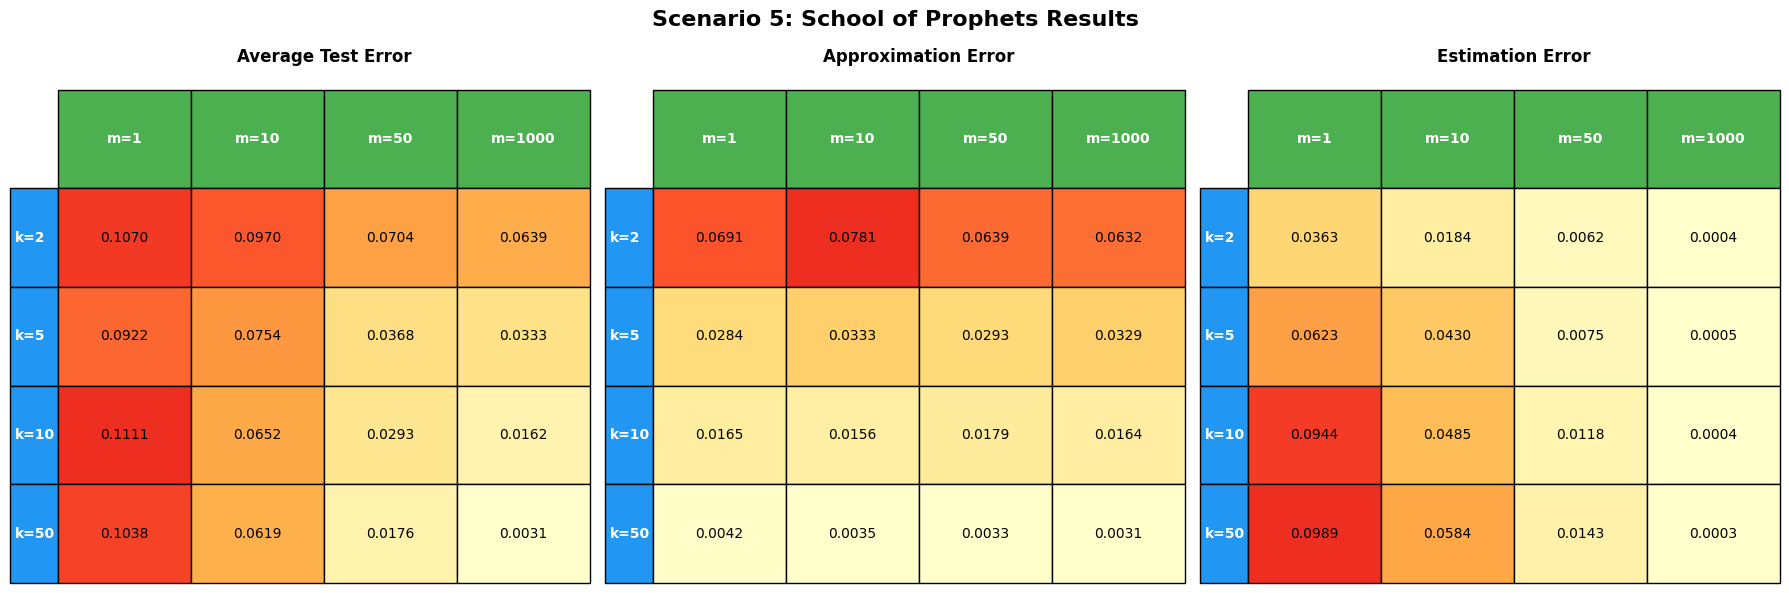

{(2, 1): {'mean_test_error': 0.10702000000000002,
  'best_model_count': 52,
  'mean_approximation_error': 0.06908717680357436,
  'mean_estimation_error': 0.0362944451370836,
  'within_1_percent_count': 57},
 (2, 10): {'mean_test_error': 0.09695999999999999,
  'best_model_count': 65,
  'mean_approximation_error': 0.07808463933672327,
  'mean_estimation_error': 0.018401843840332013,
  'within_1_percent_count': 68},
 (2, 50): {'mean_test_error': 0.07043,
  'best_model_count': 84,
  'mean_approximation_error': 0.06387230959260023,
  'mean_estimation_error': 0.006213162674923243,
  'within_1_percent_count': 89},
 (2, 1000): {'mean_test_error': 0.06388,
  'best_model_count': 96,
  'mean_approximation_error': 0.06321012936533013,
  'mean_estimation_error': 0.0004357450363401891,
  'within_1_percent_count': 98},
 (5, 1): {'mean_test_error': 0.09222000000000001,
  'best_model_count': 22,
  'mean_approximation_error': 0.02841551125243932,
  'mean_estimation_error': 0.06234277544794505,
  'within

In [172]:
Scenario_5()

## scenario 6

In [ ]:
def Scenario_6():
    """
    Question 6.
    The Bias-Variance Tradeoff.
    You may change the input & output parameters of the function as you wish.
    """
    ############### YOUR CODE GOES HERE ###############
    np.random.seed(0)
    with open('scenario_six_prophets.pkl', 'rb') as f:
        data_dict = pickle.load(f)
    
    hypothesis1 = data_dict['hypothesis1']
    hypothesis2 = data_dict['hypothesis2']
    
    # Run comparison
    experiment = BiasComplexityExperiment(data, hypothesis1, hypothesis2)
    h1_results, h2_results = experiment.run_comparison(n_trials=100, n_train_games=10)
    
    # Compute metrics
    h1_metrics = experiment.compute_metrics(h1_results)
    h2_metrics = experiment.compute_metrics(h2_results)
    
    # Print results
    print("Hypothesis 1 (5 prophets):")
    print(f"  Mean test error: {h1_metrics['mean_test_error']:.4f}")
    print(f"  Approximation error: {h1_metrics['mean_approximation_error']:.4f}")
    print(f"  Mean estimation error: {h1_metrics['mean_estimation_error']:.4f}")
    
    print("\nHypothesis 2 (500 prophets):")
    print(f"  Mean test error: {h2_metrics['mean_test_error']:.4f}")
    print(f"  Approximation error: {h2_metrics['mean_approximation_error']:.4f}")
    print(f"  Mean estimation error: {h2_metrics['mean_estimation_error']:.4f}")
    
    # Plot histograms
    fig = experiment.plot_comparison(h1_metrics, h2_metrics)
    plt.savefig('scenario_6_histograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return h1_metrics, h2_metrics

Hypothesis 1 (5 prophets):
  Mean test error: 0.3570
  Approximation error: 0.3230
  Mean estimation error: 0.0306

Hypothesis 2 (500 prophets):
  Mean test error: 0.3044
  Approximation error: 0.2500
  Mean estimation error: 0.0545


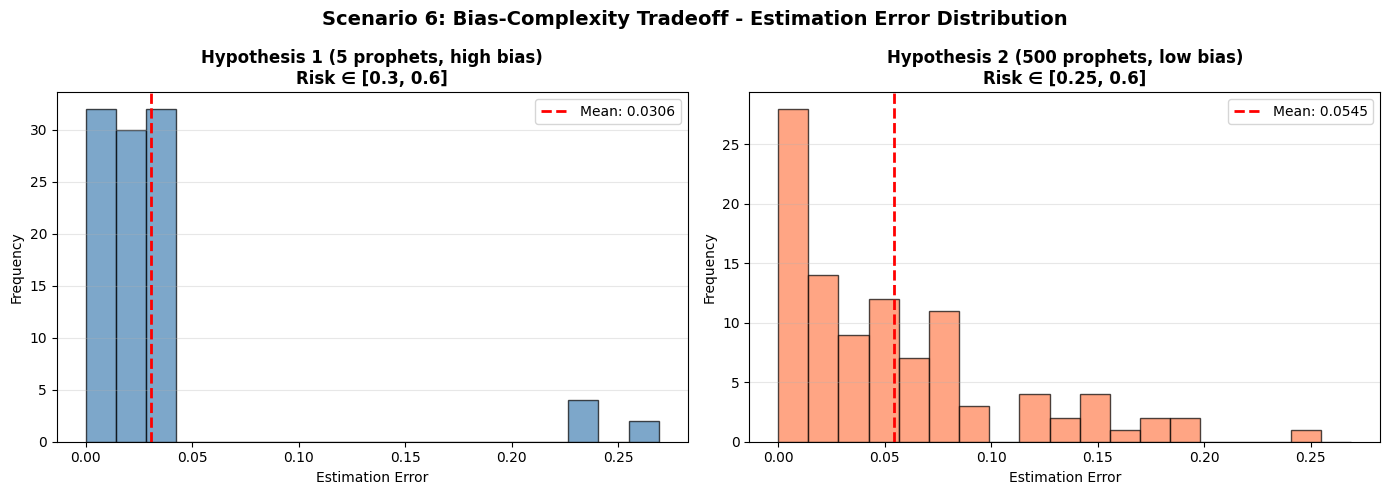

In [ ]:
_ = Scenario_6()

we play with hypothesis class size.
hypothesis 1: 5,
H 2: 500. 

we sample 10 train games to select prophet. 
from each H we select by ERM.
test both on the the data. 

run 10 trials.

for each H: avg test err, avg apprx error and estimation err. 

for each H: plot the histogram of estimation errors

Scenario 1 Results:
Scenario 2 Results:
Scenario 3 Results:
Average test error: 0.0930
Best prophet chosen: 3/100 times
Within 1% of best: 8/100 times
Mean approximation error: 0.0064
Mean estimation error: 0.0852
Scenario 4 Results:
Average test error: 0.0150
Best prophet chosen: 23/100 times
Within 1% of best: 63/100 times
Mean approximation error: 0.0064
Mean estimation error: 0.0079
Scenario 5 Results:

Running k=2, m=1...

Running k=2, m=10...

Running k=2, m=50...

Running k=2, m=1000...

Running k=5, m=1...

Running k=5, m=10...

Running k=5, m=50...

Running k=5, m=1000...

Running k=10, m=1...

Running k=10, m=10...

Running k=10, m=50...

Running k=10, m=1000...

Running k=50, m=1...

Running k=50, m=10...

Running k=50, m=50...

Running k=50, m=1000...


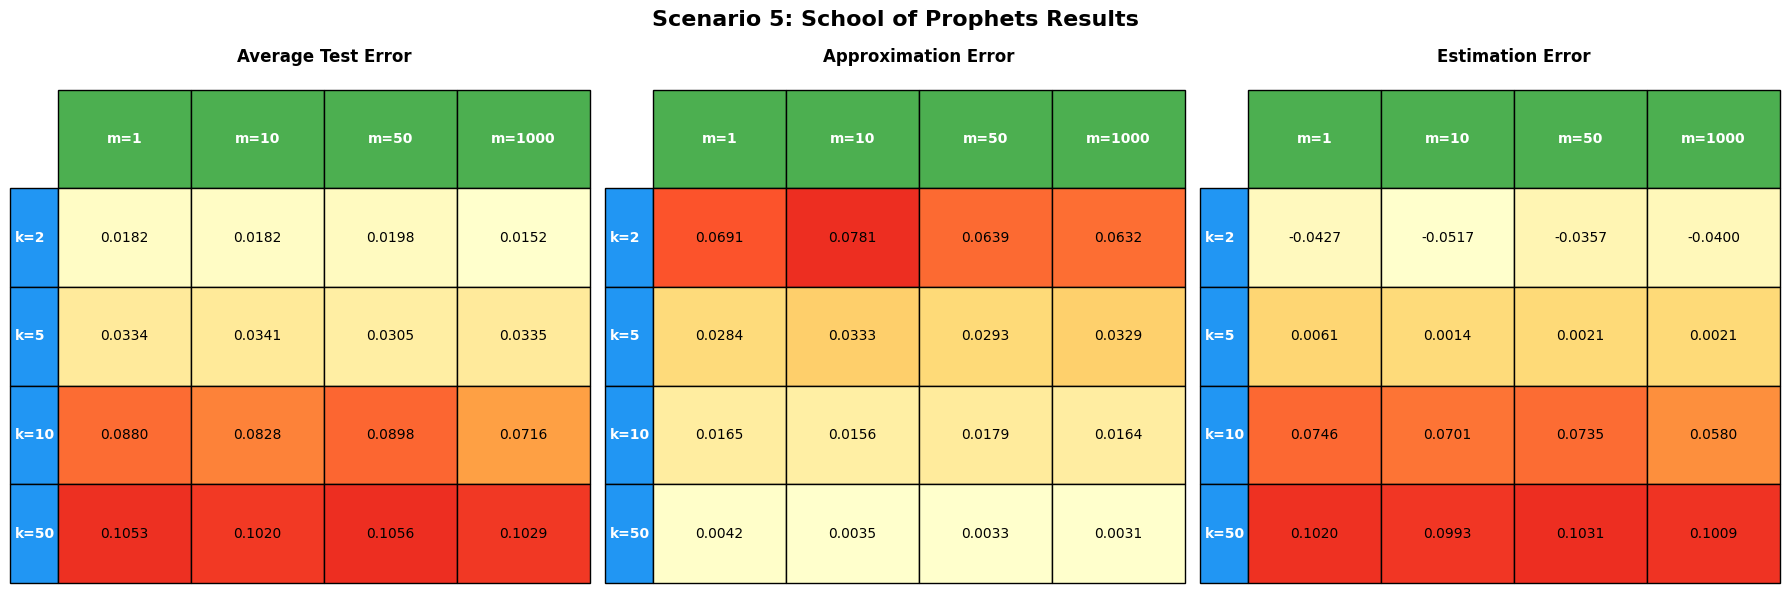

Scenario 6 Results:
Hypothesis 1 (5 prophets):
  Mean test error: 0.3570
  Approximation error: 0.3230
  Mean estimation error: 0.0306

Hypothesis 2 (500 prophets):
  Mean test error: 0.3044
  Approximation error: 0.2500
  Mean estimation error: 0.0545


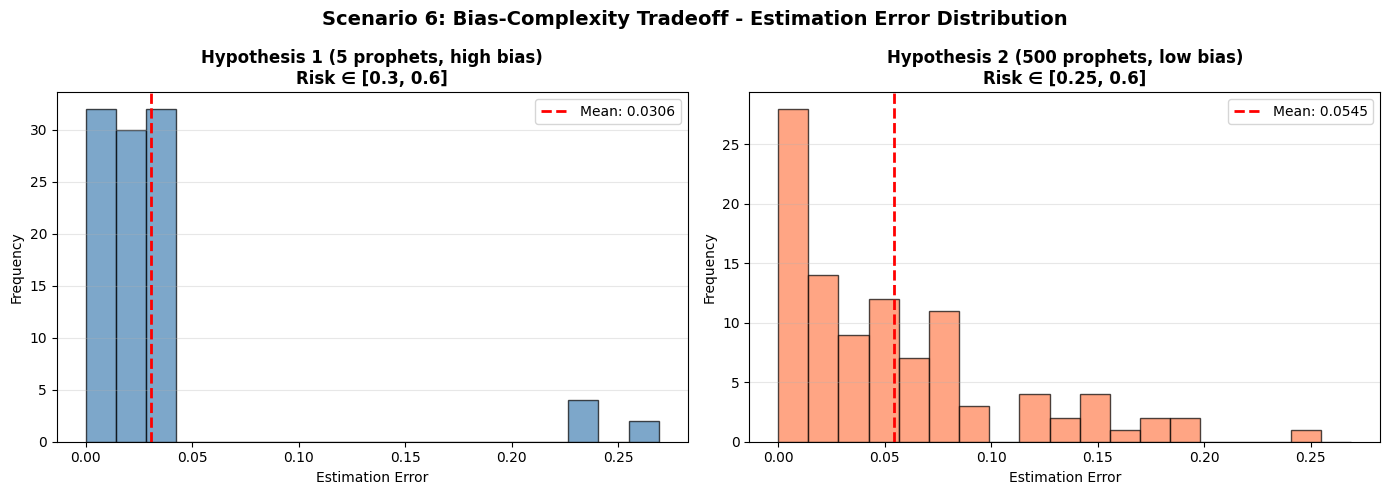

In [ ]:
if __name__ == '__main__':
    

    print(f'Scenario 1 Results:')
    Scenario_1()

    print(f'Scenario 2 Results:')
    Scenario_2()

    print(f'Scenario 3 Results:')
    Scenario_3()

    print(f'Scenario 4 Results:')
    Scenario_4()

    print(f'Scenario 5 Results:')
    Scenario_5()

    print(f'Scenario 6 Results:')
    Scenario_6()

# PAC learning analysis

important terms describing a model (a prophet):

**True risk**: ground truth of prophet probabilaty of being correct on **true** population - not the train or test set. 

**empirical risk** - measured error on trianing. 
The **ERM algorithm** simply chooses the prophet with the fewest training errors.   


**approximation error (Bias)**: *True risk* of best **available** prophet in class. ie **how well can we possible do**.

**estiamtion error**: diff in true eisk,  between **selected** and best available: `|selected - approx|. `
**how much worse than the best we could have done**. 

**overfitting**: accidnently choosing sub-obtimal model. the moe models in class, the more likely to find one that happened to have low empirical risk. 

case:

|H| = 100.
accuarcy eta = 0.05. 


delata (confidence) = 0.01. 

our estimation error (worse than best) is higher than eta in up to delta cases. 

we select a model based on M training samples. 

formula for PAC:
n >= (2*log(2m/delta))/eta


recall that ERM chooses based on trainig. the larger the trianing, we suppose the more general it is, thus less chance that a model accidently good. 

hence we see: we need more samples when:
1. larger class (m incresaed) - more chances that one happens to be correct on train without being actually better.
2. higher confidence (lower delta). less cases where we 'failed'
3. lower eta - more stringent criteria of success. 



In [ ]:
def min_samples_for_pac(
    h:int = 100,
    eta: float = 0.05,
    delta: float = 0.01
):

    n=2 * np.log(2 * h / delta) / eta
    return n



   
min_for_pac(h=200)

NameError: name 'min_for_pac' is not defined

5.298317366548036

In [ ]:
#def m_from_eta
m:int = 100
eta: float = 0.05
delta: float = 0.01



In [ ]:
# print 



PAC LEARNING ANALYSIS

QUESTION 1: Compute minimal number of samples

Input Parameters:
  |H| (hypothesis class size) = 100
  epsilon (desired accuracy)  = 0.05
  delta (confidence level)    = 0.01

Output:
  m (minimal samples required) = 396.14
  m (rounded up)               = 397

QUESTION 2: Analyze change when |H| is doubled

Input Parameters:
  |H| (hypothesis class size) = 200 (doubled)
  epsilon (desired accuracy)  = 0.05
  delta (confidence level)    = 0.01

Output:
  m (minimal samples required) = 423.87
  m (rounded up)               = 424

Comparison:
  Original m (|H|=100):  396.14
  New m (|H|=200):       423.87
  Absolute change:       27.73
  Relative change:       7.00%

Interpretation:
  When |H| doubles, m increases by only 7.00%
  This is because m grows LOGARITHMICALLY with |H|, not linearly.
  Doubling hypotheses adds only log(2) ~ 0.693 to the numerator.

QUESTION 3: Plot m as a function of epsilon in [0.01, 0.2]


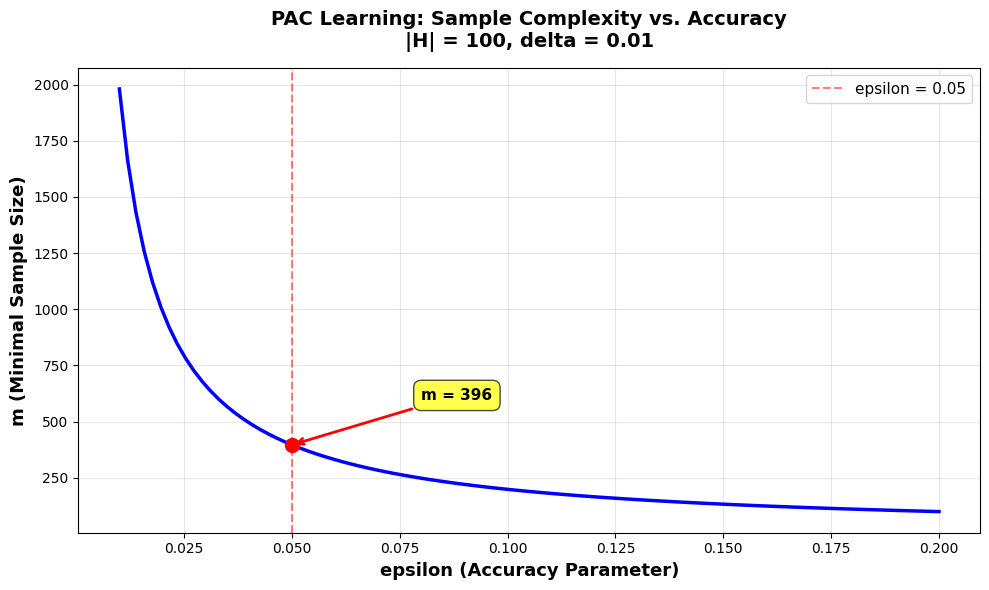


Key Values:
  m(epsilon=0.01) = 1980.70
  m(epsilon=0.05) = 396.14
  m(epsilon=0.10) = 198.07
  m(epsilon=0.20) = 99.03

Interpretation:
  - m decreases HYPERBOLICALLY as epsilon increases (m proportional to 1/epsilon)
  - Higher accuracy requirements (smaller epsilon) need MORE samples
  - To halve the error (epsilon: 0.1 -> 0.05), we need to DOUBLE the samples
  - The relationship is INVERSELY PROPORTIONAL:
    reducing epsilon by factor k increases m by factor k
  - This makes high accuracy expensive in terms of sample requirements

QUESTION 4: Plot m as a function of delta in [10^-4, 0.1] (log scale)


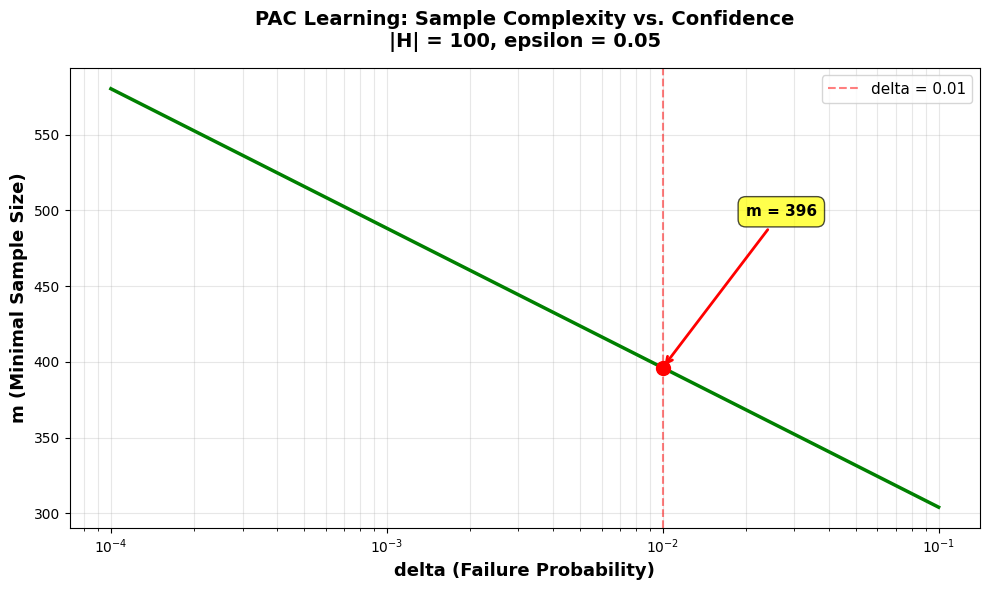


Key Values:
  m(delta=0.0001) = 580.35
  m(delta=0.001)  = 488.24
  m(delta=0.01)   = 396.14
  m(delta=0.1)    = 304.04

Interpretation:
  - m increases LOGARITHMICALLY as delta decreases (m proportional to log(1/delta))
  - Higher confidence (smaller delta) requires more samples, but the increase
    is LOGARITHMIC, not linear - this is very favorable!
  - Reducing delta by factor of 10 adds only log(10) ~ 2.3 to the numerator
  - Going from delta=0.1 to delta=0.0001 (1000x more confident) increases m by
    only ~1.91x
  - This makes achieving high confidence relatively CHEAP in terms of samples
  - Unlike accuracy (epsilon), confidence improvements scale very efficiently

SUMMARY OF KEY FINDINGS

PAC Learning Formula: m = (2/epsilon) * log(2|H|/delta)

Scaling behaviors:
  1. m grows LOGARITHMICALLY with |H| - very favorable
  2. m grows INVERSELY with epsilon - expensive to improve accuracy
  3. m grows LOGARITHMICALLY with 1/delta - cheap to improve confidence

Practical implicat

In [ ]:
# ============================================================================
# PAC LEARNING ANALYSIS - Complete Implementation
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Define the PAC learning function
def min_samples_for_pac(
    h: int = 100,
    eta: float = 0.05,
    delta: float = 0.01
):
    """
    Compute minimal number of samples for PAC learnability.

    Parameters:
    -----------
    h : int
        Size of hypothesis class |H|
    eta : float
        Desired accuracy (epsilon)
    delta : float
        Confidence parameter (probability of failure)

    Returns:
    --------
    m : float
        Minimal number of samples required
    """
    m = 2 * np.log(2 * h / delta) / eta
    return m

print("="*70)
print("PAC LEARNING ANALYSIS")
print("="*70)

# ============================================================================
# QUESTION 1: Compute minimal samples for base parameters
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: Compute minimal number of samples for chosen params")
print("="*70)

h1 = 100
eta1 = 0.05
delta1 = 0.01

m1 = min_samples_for_pac(h=h1, eta=eta1, delta=delta1)

print(f"\nInput Parameters:")
print(f"  |H| (hypothesis class size) = {h1}")
print(f"  epsilon (desired accuracy)  = {eta1}")
print(f"  delta (confidence level)    = {delta1}")
print(f"\nOutput:")
print(f"  m (minimal samples required) = {m1:.2f}")
print(f"  m (rounded up)               = {int(np.ceil(m1))}")

# ============================================================================
# QUESTION 2: Analyze change when hypotheses doubled
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: Analyze change when |H| is doubled")
print("="*70)

h2 = 200
m2 = min_samples_for_pac(h=h2, eta=eta1, delta=delta1)

print(f"\nInput Parameters:")
print(f"  |H| (hypothesis class size) = {h2} (doubled)")
print(f"  epsilon (desired accuracy)  = {eta1}")
print(f"  delta (confidence level)    = {delta1}")
print(f"\nOutput:")
print(f"  m (minimal samples required) = {m2:.2f}")
print(f"  m (rounded up)               = {int(np.ceil(m2))}")

print(f"\nComparison:")
print(f"  Original m (|H|=100):  {m1:.2f}")
print(f"  New m (|H|=200):       {m2:.2f}")
print(f"  Absolute change:       {m2 - m1:.2f}")
print(f"  Relative change:       {(m2 - m1) / m1 * 100:.2f}%")

print(f"\nInterpretation:")
print(f"  When |H| doubles, m increases by only {(m2 - m1) / m1 * 100:.2f}%")
print(f"  This is because m grows LOGARITHMICALLY with |H|, not linearly.")
print(f"  Doubling hypotheses adds only log(2) ~ 0.693 to the numerator.")

# ============================================================================
# QUESTION 3: Plot m as a function of epsilon
# ============================================================================
print("\n" + "="*70)
print("QUESTION 3: Plot m as a function of epsilon in [0.01, 0.2]")
print("="*70)

# Generate epsilon values
eta_values = np.linspace(0.01, 0.2, 100)
m_vs_eta = [min_samples_for_pac(h=100, eta=eta, delta=0.01) for eta in eta_values]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(eta_values, m_vs_eta, 'b-', linewidth=2.5)
ax.grid(True, alpha=0.3)
ax.set_xlabel('epsilon (Accuracy Parameter)', fontsize=13, fontweight='bold')
ax.set_ylabel('m (Minimal Sample Size)', fontsize=13, fontweight='bold')
ax.set_title('PAC Learning: Sample Complexity vs. Accuracy\n|H| = 100, delta = 0.01',
             fontsize=14, fontweight='bold', pad=15)

# Add annotations for key points
ax.axvline(0.05, color='r', linestyle='--', alpha=0.5, label='epsilon = 0.05')
m_at_005 = min_samples_for_pac(h=100, eta=0.05, delta=0.01)
ax.plot(0.05, m_at_005, 'ro', markersize=10)
ax.annotate(f'm = {m_at_005:.0f}', xy=(0.05, m_at_005),
            xytext=(0.08, m_at_005 + 200),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nKey Values:")
print(f"  m(epsilon=0.01) = {min_samples_for_pac(h=100, eta=0.01, delta=0.01):.2f}")
print(f"  m(epsilon=0.05) = {min_samples_for_pac(h=100, eta=0.05, delta=0.01):.2f}")
print(f"  m(epsilon=0.10) = {min_samples_for_pac(h=100, eta=0.10, delta=0.01):.2f}")
print(f"  m(epsilon=0.20) = {min_samples_for_pac(h=100, eta=0.20, delta=0.01):.2f}")

print(f"\nInterpretation:")
print(f"  - m decreases HYPERBOLICALLY as epsilon increases (m proportional to 1/epsilon)")
print(f"  - Higher accuracy requirements (smaller epsilon) need MORE samples")
print(f"  - To halve the error (epsilon: 0.1 -> 0.05), we need to DOUBLE the samples")
print(f"  - The relationship is INVERSELY PROPORTIONAL:")
print(f"    reducing epsilon by factor k increases m by factor k")
print(f"  - This makes high accuracy expensive in terms of sample requirements")

# ============================================================================
# QUESTION 4: Plot m as a function of delta (log scale)
# ============================================================================
print("\n" + "="*70)
print("QUESTION 4: Plot m as a function of delta in [10^-4, 0.1] (log scale)")
print("="*70)

# Generate delta values on log scale
delta_values = np.logspace(-4, -1, 100)  # 10^-4 to 10^-1
m_vs_delta = [min_samples_for_pac(h=100, eta=0.05, delta=delta) for delta in delta_values]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(delta_values, m_vs_delta, 'g-', linewidth=2.5)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlabel('delta (Failure Probability)', fontsize=13, fontweight='bold')
ax.set_ylabel('m (Minimal Sample Size)', fontsize=13, fontweight='bold')
ax.set_title('PAC Learning: Sample Complexity vs. Confidence\n|H| = 100, epsilon = 0.05',
             fontsize=14, fontweight='bold', pad=15)

# Add annotations for key points
ax.axvline(0.01, color='r', linestyle='--', alpha=0.5, label='delta = 0.01')
m_at_001 = min_samples_for_pac(h=100, eta=0.05, delta=0.01)
ax.plot(0.01, m_at_001, 'ro', markersize=10)
ax.annotate(f'm = {m_at_001:.0f}', xy=(0.01, m_at_001),
            xytext=(0.02, m_at_001 + 100),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nKey Values:")
print(f"  m(delta=0.0001) = {min_samples_for_pac(h=100, eta=0.05, delta=0.0001):.2f}")
print(f"  m(delta=0.001)  = {min_samples_for_pac(h=100, eta=0.05, delta=0.001):.2f}")
print(f"  m(delta=0.01)   = {min_samples_for_pac(h=100, eta=0.05, delta=0.01):.2f}")
print(f"  m(delta=0.1)    = {min_samples_for_pac(h=100, eta=0.05, delta=0.1):.2f}")

print(f"\nInterpretation:")
print(f"  - m increases LOGARITHMICALLY as delta decreases (m proportional to log(1/delta))")
print(f"  - Higher confidence (smaller delta) requires more samples, but the increase")
print(f"    is LOGARITHMIC, not linear - this is very favorable!")
print(f"  - Reducing delta by factor of 10 adds only log(10) ~ 2.3 to the numerator")
print(f"  - Going from delta=0.1 to delta=0.0001 (1000x more confident) increases m by")
m_ratio = min_samples_for_pac(h=100, eta=0.05, delta=0.0001) / min_samples_for_pac(h=100, eta=0.05, delta=0.1)
print(f"    only ~{m_ratio:.2f}x")
print(f"  - This makes achieving high confidence relatively CHEAP in terms of samples")
print(f"  - Unlike accuracy (epsilon), confidence improvements scale very efficiently")

print("\n" + "="*70)
print("SUMMARY OF KEY FINDINGS")
print("="*70)
print("\nPAC Learning Formula: m = (2/epsilon) * log(2|H|/delta)")
print("\nScaling behaviors:")
print("  1. m grows LOGARITHMICALLY with |H| - very favorable")
print("  2. m grows INVERSELY with epsilon - expensive to improve accuracy")
print("  3. m grows LOGARITHMICALLY with 1/delta - cheap to improve confidence")
print("\nPractical implications:")
print("  - Adding more hypotheses is relatively cheap")
print("  - Improving accuracy is expensive (linear cost)")
print("  - Improving confidence is cheap (logarithmic cost)")
print("="*70)

In [ ]:
epsilon = 0.05
delta = 0.01
h = 100

(2/epsilon) * np.log(2)

27.725887222397812